In [4]:
import cv2
from ultralytics import YOLO
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import time

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys
sys.path.append(os.path.abspath('..'))

from src.const import *
from src.morph import color_mask, dilate, erode, opening, closing, external_border

In [5]:
range_white = 45

lower_white = [max(0, c - range_white) for c in WHITE_CHESS]
upper_white = [min(240, c + range_white) for c in WHITE_CHESS]

"""
Custom YOLO train over Roboflow dataset on corner of chessboard
"""
# model = YOLO(r'C:\Users\Student11\Documents\git\ELEN-CV\project\yolo\yolo11n_custom6h.pt')
model = YOLO(r'..\weights\best.pt')
model2 = YOLO(r'..\weights\best11m.pt')

# !!!!! not use  mov, doesnt work, convert to avi
video_path = r'..\video\IMG_0485.avi'

In [6]:
t_hull = []
t_yolo = []
t_boxes_resized = []
t_boxes_original = []
t_cluster_avg = []

In [17]:
PLOT_EACH_FRAME = True

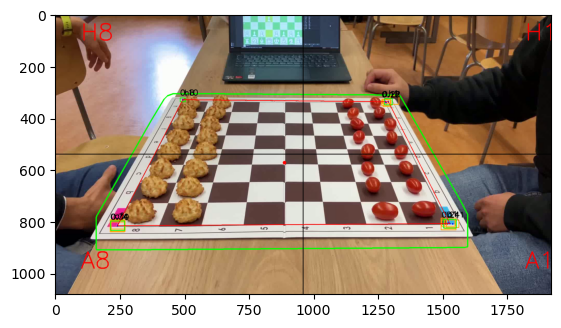

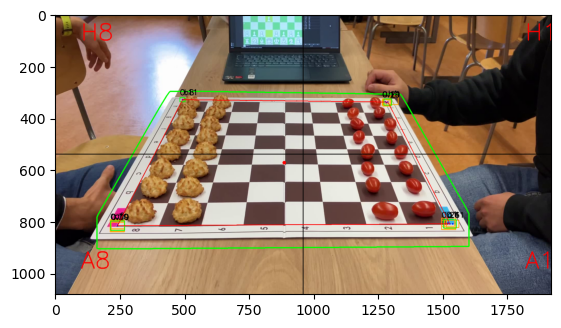

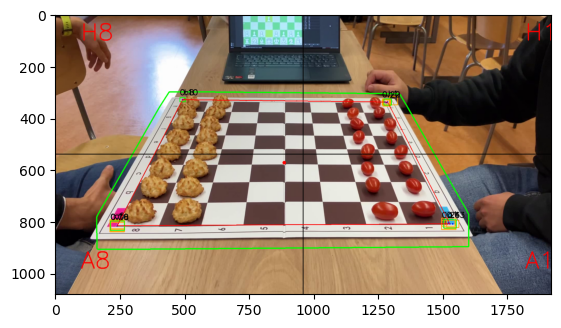

In [18]:
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    # print("Error opening the video file")
    exit()
else:
    # Get frame rate information
    fps = int(cap.get(5))
    # print("Frame Rate : ",fps,"frames per second")  
    
    # Get frame count, if you see -1, the video is not good
    frame_count = cap.get(7)
    # print("Frame count : ", frame_count)
    
    # Get the width and height of frame
    frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    # print("Frame width : ", frame_width)
    # print("Frame height : ", frame_height)

frame_idx = 0

while True:
    ret, frame = cap.read()
    
    # scale factor horizontal and vertical
    fx = 640 / frame_width
    fy = 640 / frame_height
    
    frame_resized = cv2.resize(frame, (640, 640), interpolation=cv2.INTER_AREA)

    if not ret:
        break  # Exit loop if no frames are returned (end of video)

    start_time = time.time()

    hull, combined_contour = external_border(frame, lower_white, upper_white)

    t_hull.append(time.time() - start_time)
    # print(f"hull detection: {t_hull[-1]:0.6f} seconds")

    start_time = time.time()

    # Result of the corners detection with YOLO
    results = model.track(source=frame, persist=True, verbose=False, show=False, tracker="bytetrack.yaml", conf=0.1, iou=0.1)
    results2 = model2.track(source=frame, persist=True, verbose=False, show=False, tracker="bytetrack.yaml", conf=0.1, iou=0.1)
    
    results.extend(results2)
    
    results_resized = model.track(source=frame_resized, persist=True, verbose=False, show=False, tracker="bytetrack.yaml", conf=0.1, iou=0.1)
    results2_resized = model2.track(source=frame_resized, persist=True, verbose=False, show=False, tracker="bytetrack.yaml", conf=0.1, iou=0.1)
    
    results_resized.extend(results2_resized)

    t_yolo.append(time.time() - start_time)
    # print(f"YOLO detection: {t_yolo[-1]:0.6f} seconds")

    if PLOT_EACH_FRAME:
        # Draw the convex hull on the frame
        cv2.drawContours(frame, [hull], -1, (0, 255, 0), 3)
        
        # Draw vertical and horizontal lines to separate the image into 4 quadrants
        cv2.line(frame, (int(frame_width / 2), 0), (int(frame_width / 2), int(frame_height)), BLACK, 2)
        cv2.line(frame, (0, int(frame_height / 2)), (int(frame_width), int(frame_height / 2)), BLACK, 2)
        
        # Write corner labels on the image 
        shift = 100
        cv2.putText(frame, "H8",(shift, shift), cv2.FONT_HERSHEY_SIMPLEX, 3, RED, 3)
        cv2.putText(frame, "H1",(int(frame_width) - shift , shift), cv2.FONT_HERSHEY_SIMPLEX, 3, RED, 3)
        cv2.putText(frame, "A8",(shift, int(frame_height) - shift), cv2.FONT_HERSHEY_SIMPLEX, 3, RED, 3)
        cv2.putText(frame, "A1",(int(frame_width) - shift, int(frame_height) - shift), cv2.FONT_HERSHEY_SIMPLEX, 3, RED, 3)
        
    start_time = time.time()

    bbox_data = []
    
    for result in results_resized:
        for box in result.boxes:
            # Resized frame coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            confidence = box.conf[0].item()
            # check box is already tracked if not, no id
            if box.id is not None:
                label = int(box.id.item())
            else:
                label = 99
            label_text = f"{confidence:.2f}"
            
            # Map to original frame coordinates
            x1_original, y1_original = x1 / fx, y1 / fy
            x2_original, y2_original = x2 / fx, y2 / fy
            
            # Calculate the center of the bounding box
            cx_resized, cy_resized = (x1 + x2) / 2, (y1 + y2) / 2
            cx_original, cy_original = cx_resized / fx, cy_resized / fy
            
            distance = cv2.pointPolygonTest(hull, (cx_original, cy_original), True)
            if distance < -10:
                continue  # Skip this prediction if the center is not inside the hull or within 10 pixels

            bbox_data.append((cx_original, cy_original, x1_original, y1_original, x2_original, y2_original))  # Store center and box dimensions

            if PLOT_EACH_FRAME:
                # Visualize the results on the original frame
                # cv2.circle(frame, (int(cx_original), int(cy_original)), 3, BLUE, -1)
                cv2.rectangle(frame, (int(x1_original), int(y1_original)), (int(x2_original), int(y2_original)), ORANGE, 2)
                # cv2.putText(frame, label_text, (int(x1_original), int(y1_original) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, BLACK, 2)

    t_boxes_resized.append(time.time() - start_time)
    # print(f"Resized YOLO processing: {t_boxes_resized[-1]:0.6f} seconds")

    start_time = time.time()

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            confidence = box.conf[0].item()
            # check box is already tracked if not, no id
            if box.id is not None:
                label = int(box.id.item())
            else:
                label = 99
            label_text = f"{confidence:.2f}"

            cx, cy = (x1 + x2) / 2, (y1 + y2) / 2  # Center of the bounding box

            # Check if the center of the bounding box is inside the hull or within 10 pixels
            distance = cv2.pointPolygonTest(hull, (cx, cy), True)
            if distance < -10:
                continue  # Skip this prediction if the center is not inside the hull or within 10 pixels
                
            bbox_data.append((cx, cy, x1, y1, x2, y2))

            if PLOT_EACH_FRAME:
                # Visualize the results on the original frame
                cv2.circle(frame, (int(cx), int(cy)), 3, BLUE, -1)
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), ORANGE, 2)
                cv2.putText(frame, label_text, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, BLACK, 2)         

    t_boxes_original.append(time.time() - start_time)
    # print(f"Original YOLO processing: {t_boxes_original[-1]:0.6f} seconds")

    # Initialize corner coordinates
    corners = {
        "h8": [None, None],
        "h1": [None, None],
        "a8": [None, None],
        "a1": [None, None]
    }
    
    # Group bounding boxes using DBSCAN with a maximum distance of 100 pixels
    if not bbox_data:
        # print("No bounding boxes detected, clustering not performed.")
        continue

    start_time = time.time()
        
    bbox_centers = np.array([[data[0], data[1]] for data in bbox_data])  # Only centers
    clustering = DBSCAN(eps=200, min_samples=1).fit(bbox_centers)  # eps = 100 pixels

    clusters = {}
    for idx, label in enumerate(clustering.labels_):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(bbox_data[idx])  # Add full bounding box data to the cluster

    # Compute the average bounding box for each cluster
    averaged_bboxes = []
    for cluster_id, boxes in clusters.items():
        # Average the coordinates of the bounding boxes in the cluster
        avg_x1 = int(np.mean([box[2] for box in boxes]))
        avg_y1 = int(np.mean([box[3] for box in boxes]))
        avg_x2 = int(np.mean([box[4] for box in boxes]))
        avg_y2 = int(np.mean([box[5] for box in boxes]))
        avg_cx, avg_cy = (avg_x1 + avg_x2) // 2, (avg_y1 + avg_y2) // 2  # Center of the averaged bounding box
        averaged_bboxes.append((avg_x1, avg_y1, avg_x2, avg_y2, avg_cx, avg_cy))
        
        centroid_x, centroid_y = avg_cx, avg_cy

    t_cluster_avg.append(time.time() - start_time)
    # print(f"Clustering and averaging: {t_cluster_avg[-1]:0.6f} seconds")

    # print(f"Number of averaged bounding boxes: {len(averaged_bboxes)}")

    if len(averaged_bboxes) >= 4:
        centroid_x = sum([c[4] for c in averaged_bboxes]) / len(averaged_bboxes)
        centroid_y = sum([c[5] for c in averaged_bboxes]) / len(averaged_bboxes)
        centroid = (centroid_x, centroid_y)
        # print(f"Centroid of bounding box centers: {centroid}")
        # Optionally, draw the centroid on the frame
        if PLOT_EACH_FRAME:
            cv2.circle(frame, (int(centroid_x), int(centroid_y)), 7, RED, -1)

    # # Print or visualize the averaged bounding boxes
    for bbox in averaged_bboxes:
        
        x1, y1, x2, y2, cx, cy = bbox
        label_text = ""
        
        
        # Determine which corner the center belongs to
        if cx < frame.shape[1] / 2 and cy < frame.shape[0] / 2:
            corners["h8"][0], corners["h8"][1] = cx, cy
            label_text += " h8"
            
        elif cx >= frame.shape[1] / 2 and cy < frame.shape[0] / 2:
            corners["h1"][0], corners["h1"][1] = cx, cy
            label_text += " h1"

        elif cx < frame.shape[1] / 2 and cy >= frame.shape[0] / 2:
            corners["a8"][0], corners["a8"][1] = cx, cy
            label_text += " a8"

        elif cx >= frame.shape[1] / 2 and cy >= frame.shape[0] / 2:
            corners["a1"][0], corners["a1"][1] = cx, cy
            label_text += " a1"
            
        if PLOT_EACH_FRAME:
            cv2.circle(frame, (int(cx), int(cy)), 3, BLUE, -1)
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), GREEN, 2)
            cv2.putText(frame, label_text, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 1, BLACK, 2)

    # # Print corner coordinates
    # for corner, coord in corners.items():
        # if all(c is None for c in coord):
            # print(f"{corner}: (x,x)", end=" | ")
        # else:
            # print(f"{corner}:({coord[0]},{coord[1]})", end=" | ")
    # print()

    # Only draw polygon if all corner coordinates are present (neither value is None)
    if all([c[0] is not None and c[1] is not None for c in corners.values()]):
        pts = np.array([
            [int(corners["h8"][0]), int(corners["h8"][1])],
            [int(corners["h1"][0]), int(corners["h1"][1])],
            [int(corners["a1"][0]), int(corners["a1"][1])],
            [int(corners["a8"][0]), int(corners["a8"][1])]
        ], np.int32)

        pts = pts.reshape((-1, 1, 2))
        if PLOT_EACH_FRAME:
            cv2.polylines(frame, [pts], isClosed=True, color=RED, thickness=2)

        # print("All corners found")
    # print()

    if PLOT_EACH_FRAME:
        # Display the frame with annotations in an OpenCV window (updated per frame)
        # cv2.imshow('Annotated', frame)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        plt.show()


    frame_idx += 1

    if frame_idx >= 3:
        break
        
# Release the video capture
cap.release()

# Close all OpenCV windows
cv2.destroyAllWindows()


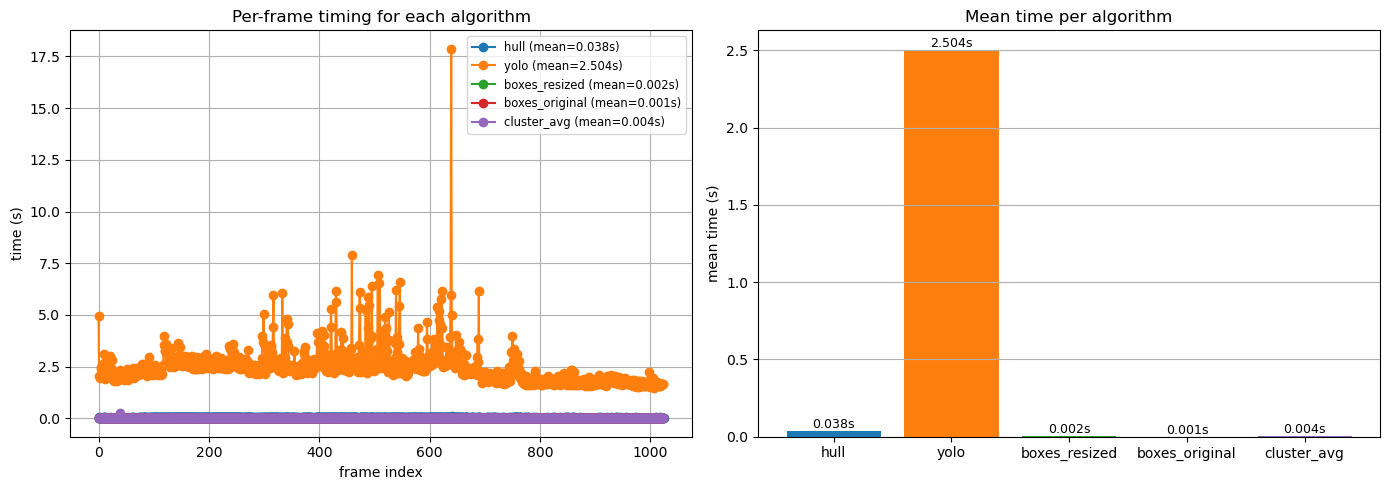

hull: 0.037695 s
yolo: 2.504441 s
boxes_resized: 0.002122 s
boxes_original: 0.000900 s
cluster_avg: 0.004280 s


In [16]:
timings = {
    'hull': np.array(t_hull),
    'yolo': np.array(t_yolo),
    'boxes_resized': np.array(t_boxes_resized),
    'boxes_original': np.array(t_boxes_original),
    'cluster_avg': np.array(t_cluster_avg),
}

# compute means (safe for empty arrays)
means = {k: (np.nanmean(v) if v.size > 0 else np.nan) for k, v in timings.items()}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# per-frame timings
for name, arr in timings.items():
    ax1.plot(np.arange(len(arr)), arr, marker='o', label=f"{name} (mean={means[name]:.3f}s)")
ax1.set_xlabel("frame index")
ax1.set_ylabel("time (s)")
ax1.set_title("Per-frame timing for each algorithm")
ax1.legend(loc='upper right', fontsize='small')
ax1.grid(True)

# mean times bar chart
names = list(means.keys())
vals = [means[n] for n in names]
bars = ax2.bar(names, vals, color=plt.cm.tab10(range(len(names))))
ax2.set_ylabel("mean time (s)")
ax2.set_title("Mean time per algorithm")
ax2.grid(axis='y')

# annotate bars with numeric mean values
for b, v in zip(bars, vals):
    if not np.isnan(v):
        ax2.text(b.get_x() + b.get_width() / 2, v, f"{v:.3f}s", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# numeric means
for k, v in means.items():
    print(f"{k}: {v:.6f} s")